### Load the data
Set the paths in the ```project_config.py``` script, then extract the data collected at the orchard from the .kml file, then load the data

In [1]:
from extract_data import extract_coordinates_from_kml

extract_coordinates_from_kml()

In [2]:
from project_config import ProjectConfig
import numpy as np

project_config = ProjectConfig()

# List of points each in the form of [lat, long]
points = project_config.load_points_from_json(project_config.points_json_path)

# convert points to numpy array
points = np.array(points)

# Create array to track group of each point
groups = np.zeros(len(points))

print("First four points: \n", points[:4])

First four points: 
 [[  44.6842015  -122.97231217]
 [  44.68419133 -122.972311  ]
 [  44.684093   -122.9723085 ]
 [  44.68398217 -122.972306  ]]


### Plot the original points

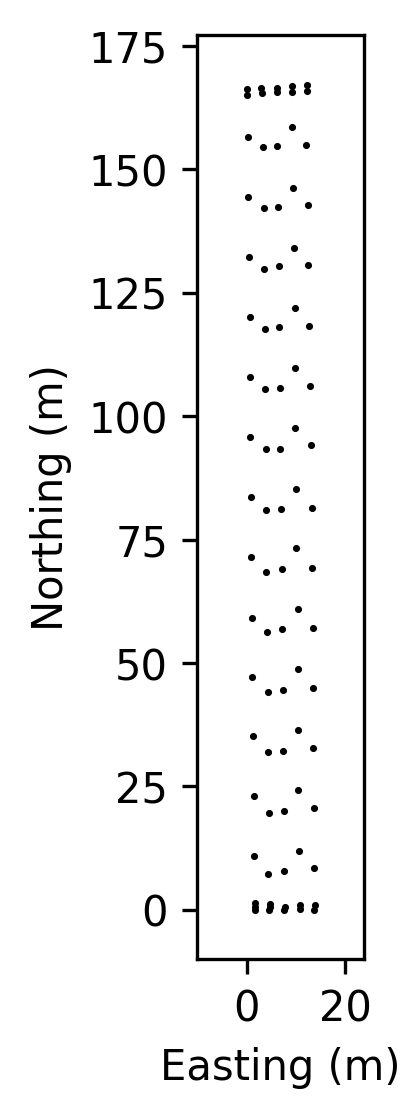

In [3]:
from plotting import plot_points

plot_points(points, groups, final_map=False)

### Identify the objects
This is done by manually setting the indexes... not a great method.

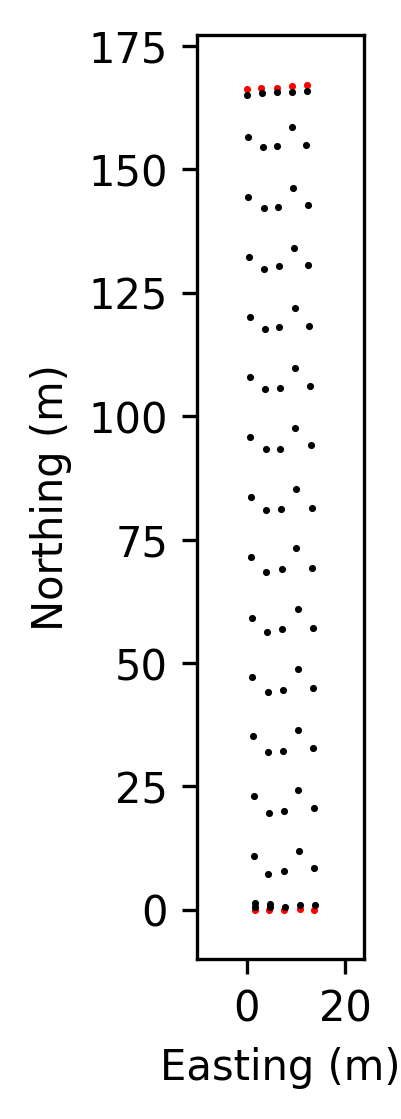

In [4]:
# Posts
post_idxs = np.array([0, 35, 37, 69, 70, 86, 17, 18, 52, 53])
groups_top = np.zeros(len(points))
groups_top[post_idxs] = 7

plot_points(points, groups_top, final_map=False)

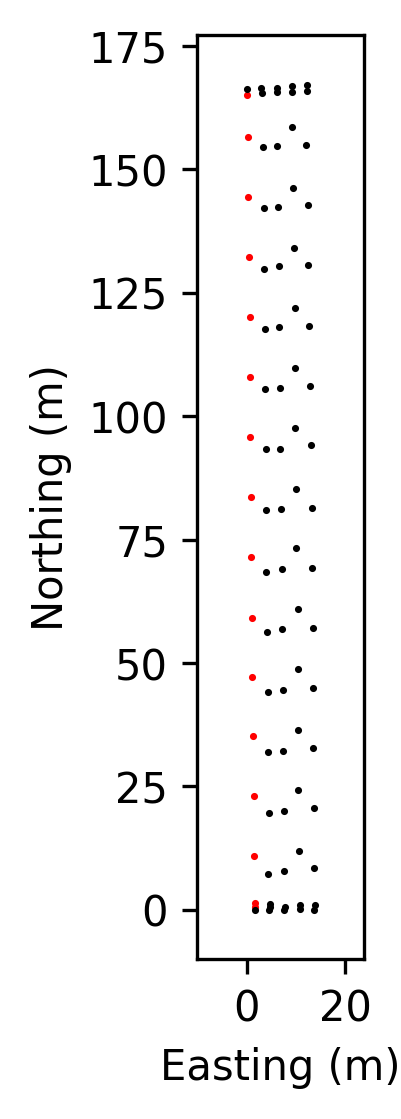

In [5]:
# Row 1
row_1_idxs = np.array([i for i in range(19, 35)])
groups_row_1 = np.zeros(len(points))
groups_row_1[row_1_idxs] = 7

plot_points(points, groups_row_1, final_map=False)

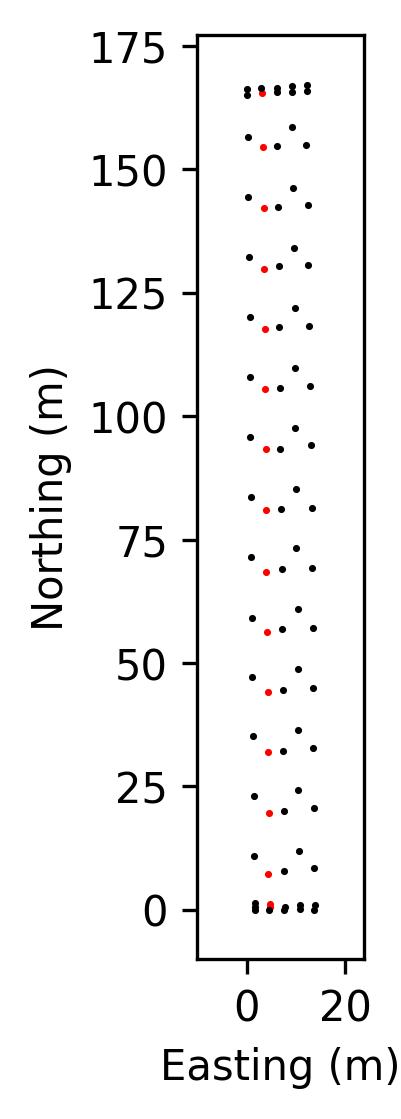

In [6]:
# Row 2
row_2_idxs = np.array([i for i in range(1, 17)])
groups_row_2 = np.zeros(len(points))
groups_row_2[row_2_idxs] = 7

plot_points(points, groups_row_2, final_map=False)

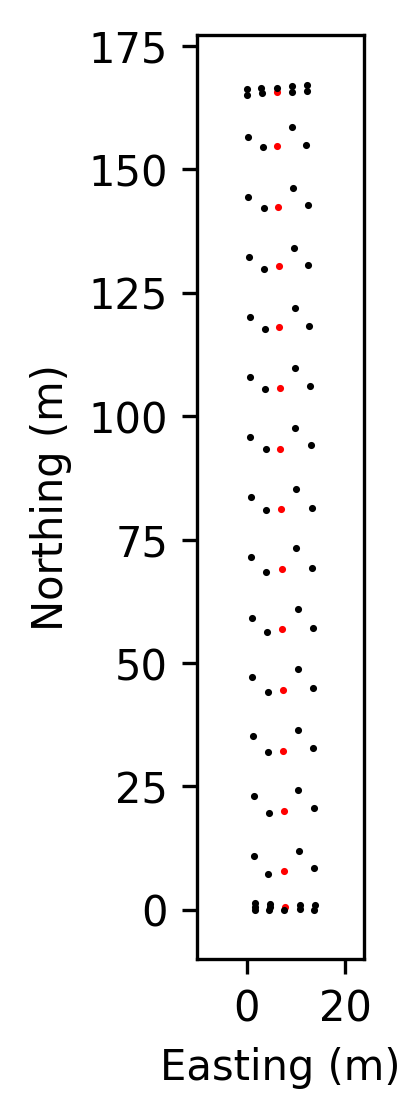

In [7]:
# Row 3
row_3_idxs = np.array([36] + [i for i in range(38, 52)])
groups_row_3 = np.zeros(len(points))
groups_row_3[row_3_idxs] = 7

plot_points(points, groups_row_3, final_map=False)

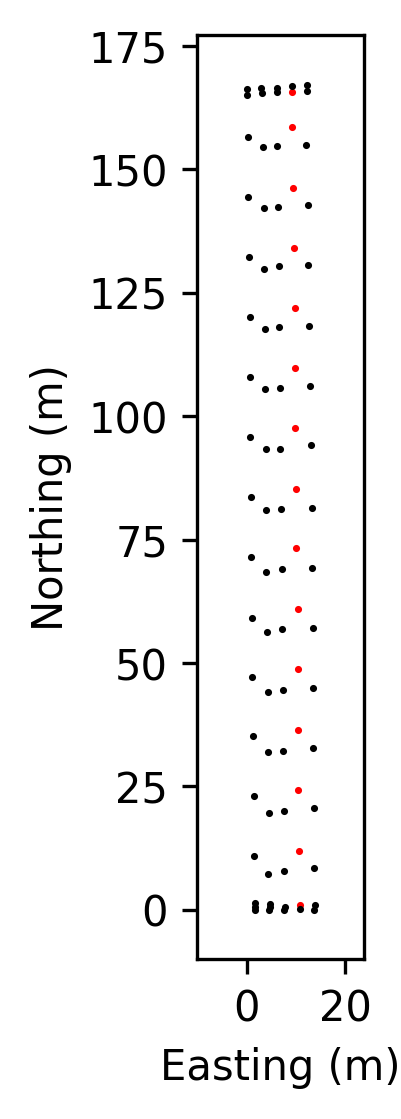

In [8]:
# Row 4
row_4_idxs = np.array([i for i in range(54, 69)])
groups_row_4 = np.zeros(len(points))
groups_row_4[row_4_idxs] = 7

plot_points(points, groups_row_4, final_map=False)

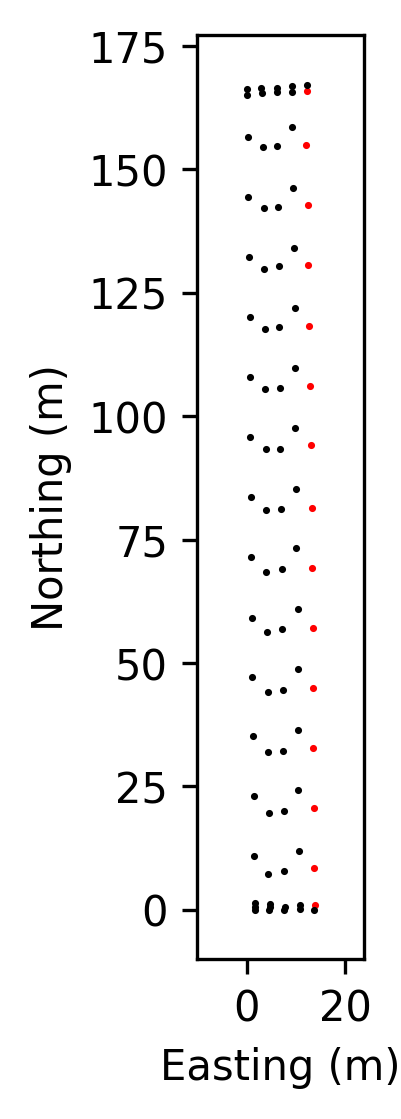

In [9]:
# Row 5
row_5_idxs = np.array([i for i in range(71, 86)])
groups_row_5 = np.zeros(len(points))
groups_row_5[row_5_idxs] = 7

plot_points(points, groups_row_5, final_map=False)

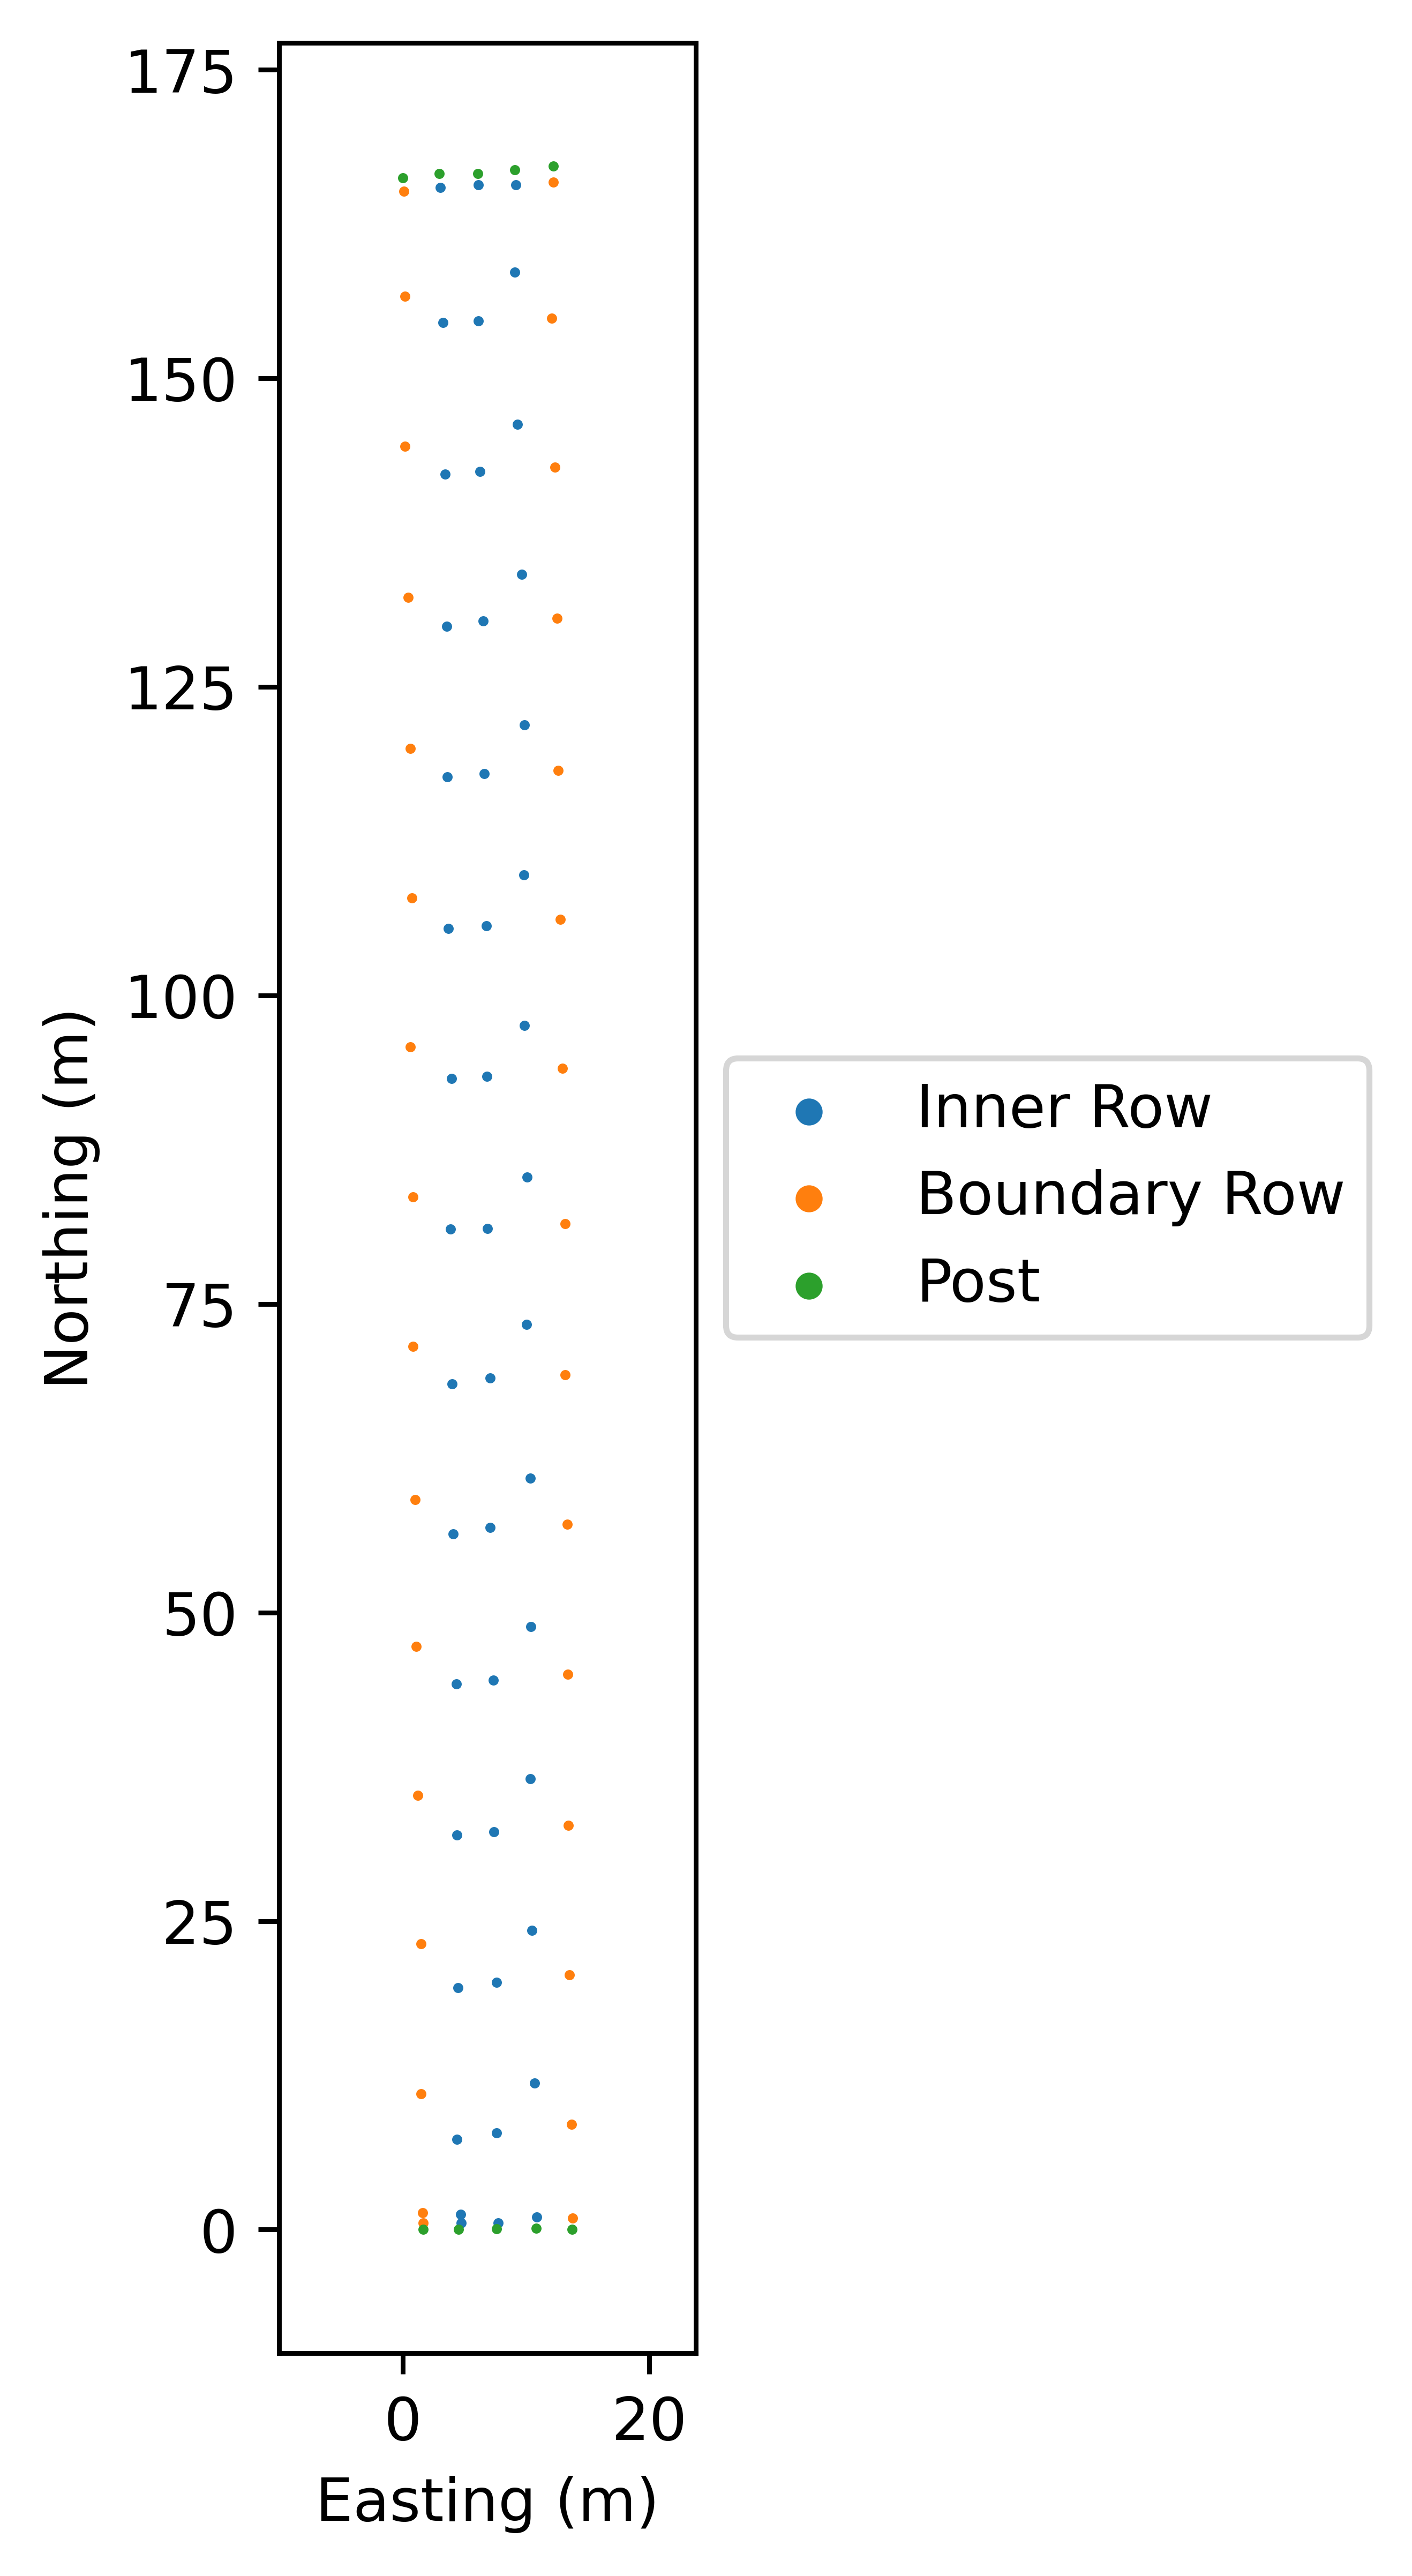

In [10]:
# Set all the group numbers
groups[post_idxs] = 6
groups[row_1_idxs] = 1
groups[row_2_idxs] = 2
groups[row_3_idxs] = 3
groups[row_4_idxs] = 4
groups[row_5_idxs] = 5

plot_points(points, groups, final_map=True)

### Now add the bushes in between
First I will setup tuples with (start_idx, end_idx, group_val, num_points_to_add), then add the num_points_to_add between the start_idx and end_idx point and give the points the group_val group number.
There are 9 bushes in between most of the marked bushes, and most of the bushes are sequential (i.e. the bush at index 5 is next to the one at index 6) so most of these points_to_add tuples can be set up in a single for loop.

In [11]:
pairs_for_9_all = pairs_for_9_all = [(21, 33), (2, 14), (38, 50), (55, 67), (72, 84)]
pairs_to_add = []
group_vals = [1, 2, 3, 4, 5]

for i, pair_for_9 in enumerate(pairs_for_9_all):
    start, end = pair_for_9
    num_pairs = end - start
    for j in range(num_pairs):
        start_idx = start + j
        end_idx = start + j + 1
        pairs_to_add.append((start_idx, end_idx, group_vals[i], 9))

Then add the exceptions to the pattern

In [12]:
# Arranged as (start_idx, end_idx, group_val, num_points_to_add)
pairs_to_add += [(1, 2, 2, 8), (36, 38, 3, 8), (54, 55, 4, 8), (71, 72, 5, 8)]
pairs_to_add += [(20, 21, 1, 7)]
pairs_to_add += [(33, 34, 1, 6), (14, 15, 2, 4), (50, 51, 3, 5), (67, 68, 4, 5), (84, 85, 5, 5)]

Now add the actual points

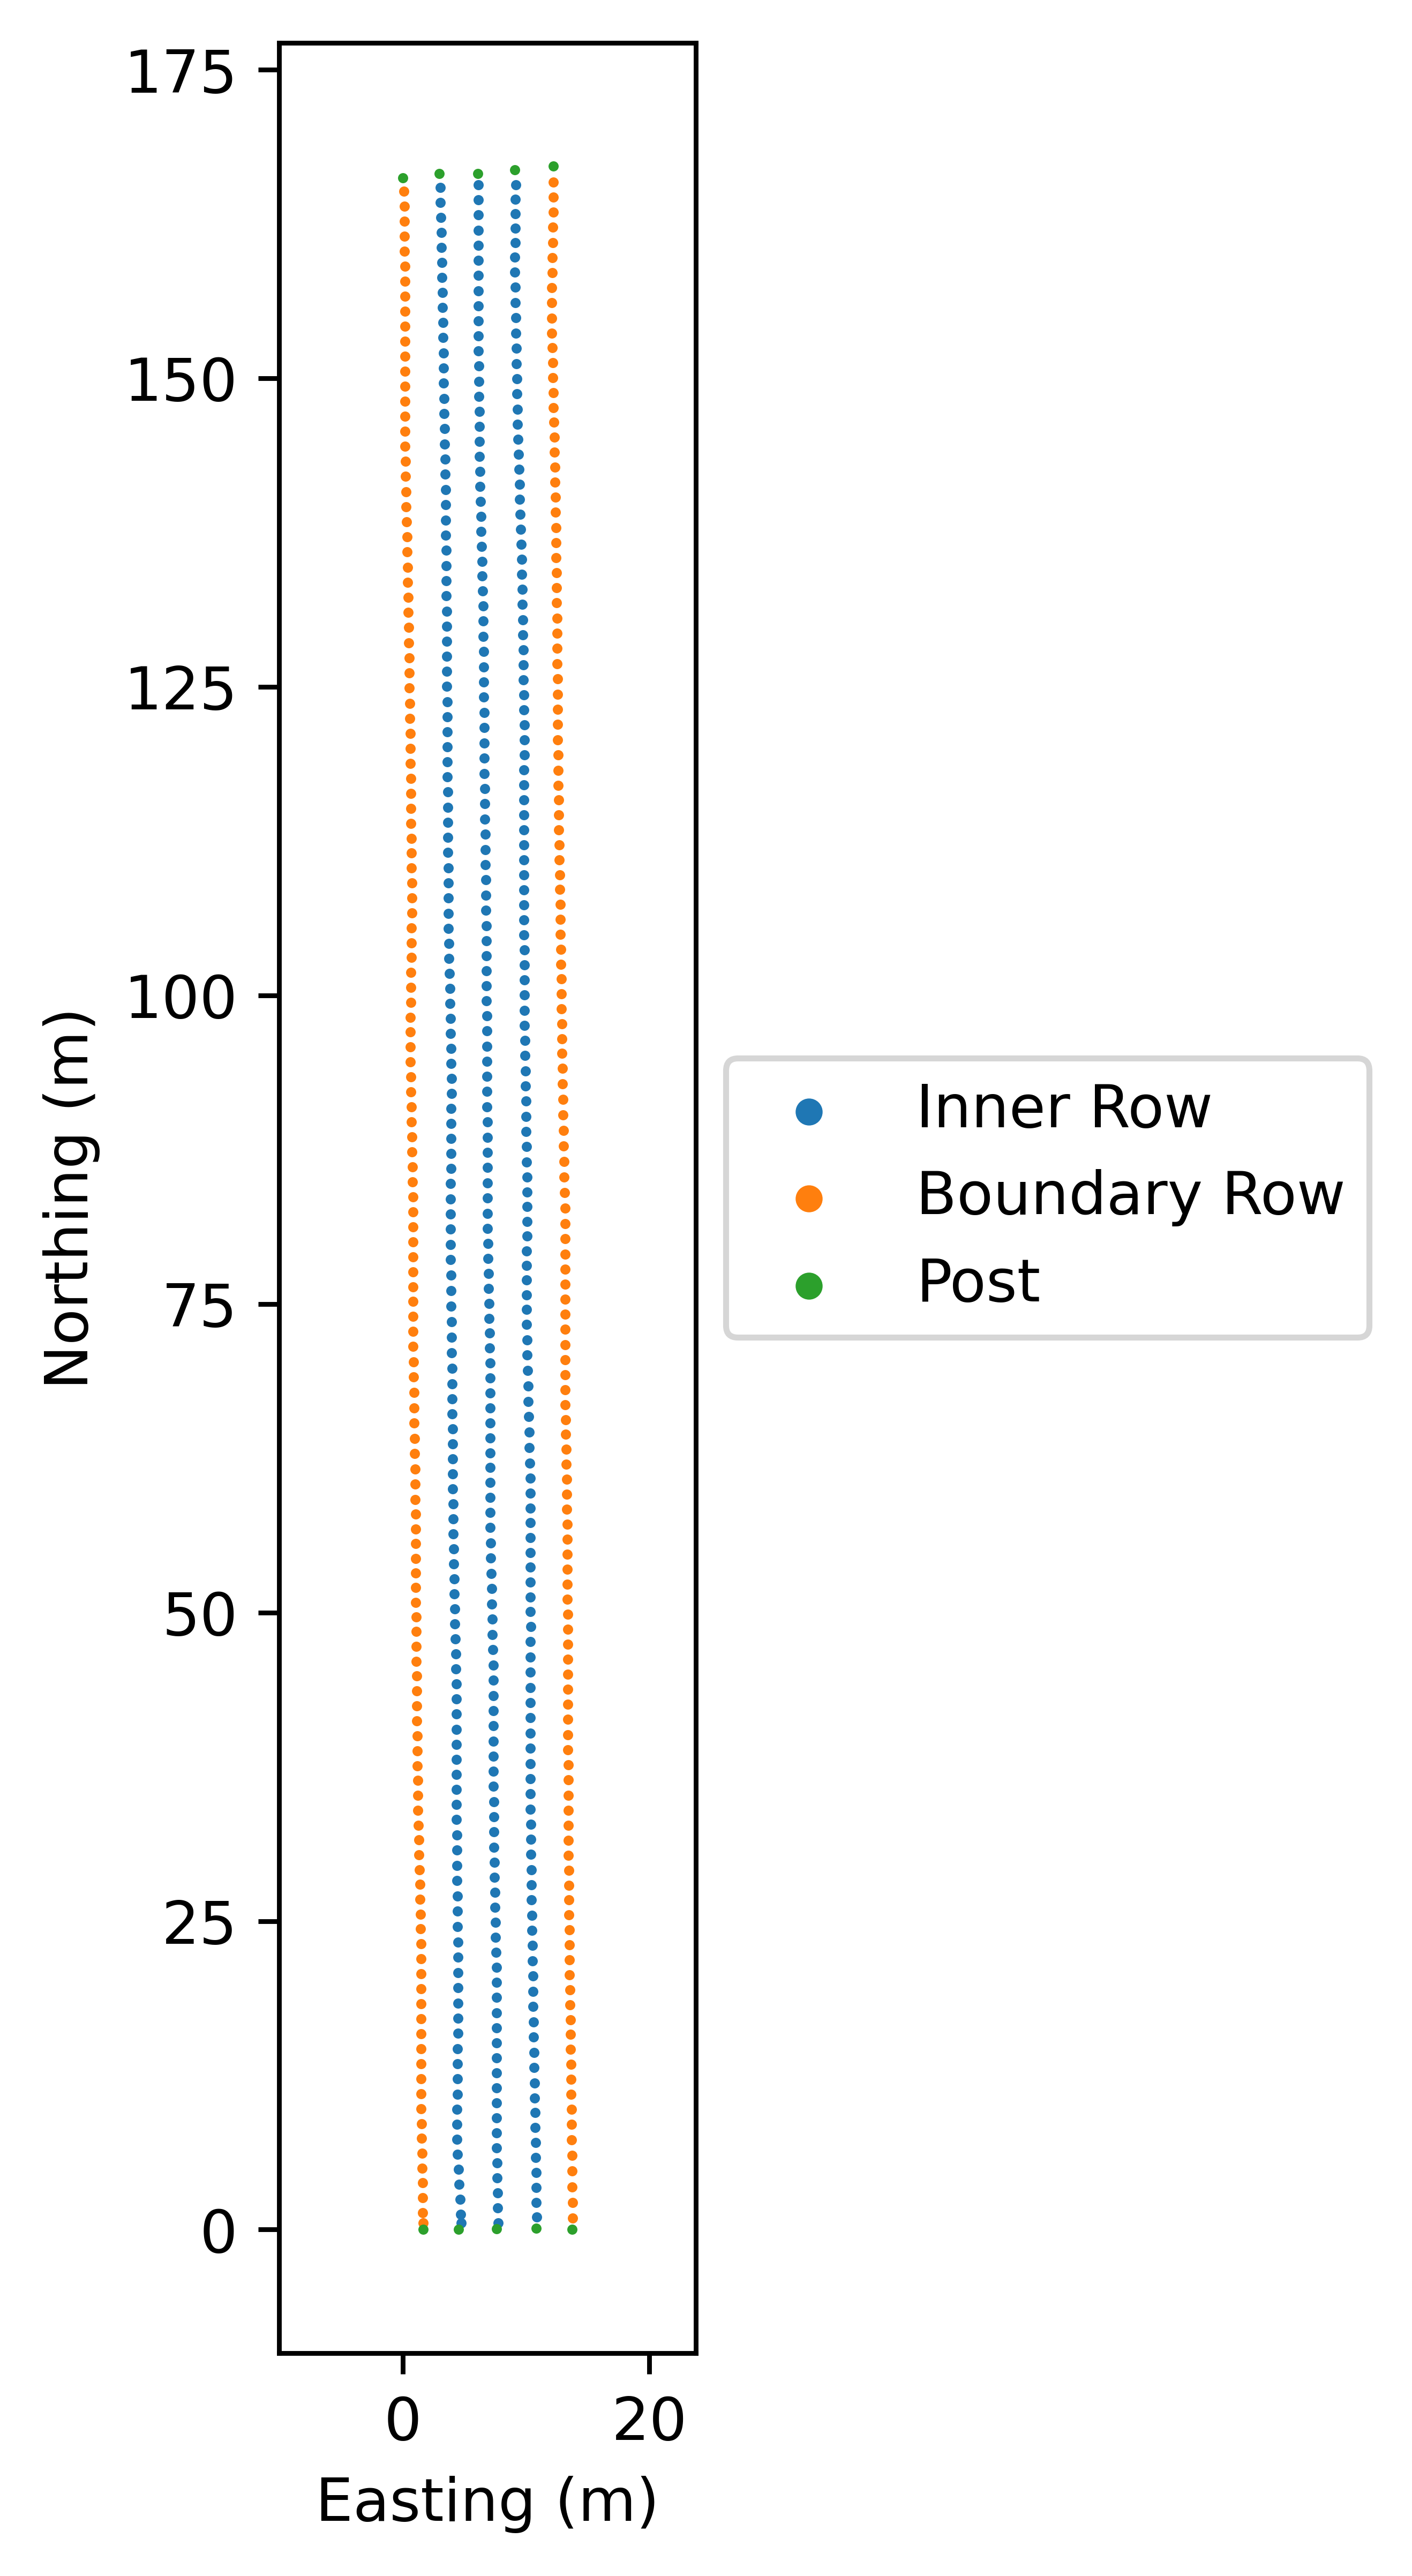

In [13]:
for start, end, group_val, num_points in pairs_to_add:
    start_point = points[start]
    end_point = points[end]
    for k in range(num_points):
        points = np.append(points, [start_point + (end_point - start_point) * (k + 1) / (num_points + 1)], axis=0)
        groups = np.append(groups, group_val)

plot_points(points, groups)

### Reorder the points 
Now the points need to be re-organized per-row to be in a more logical order. I also need to delete some bushes that aren't actually there

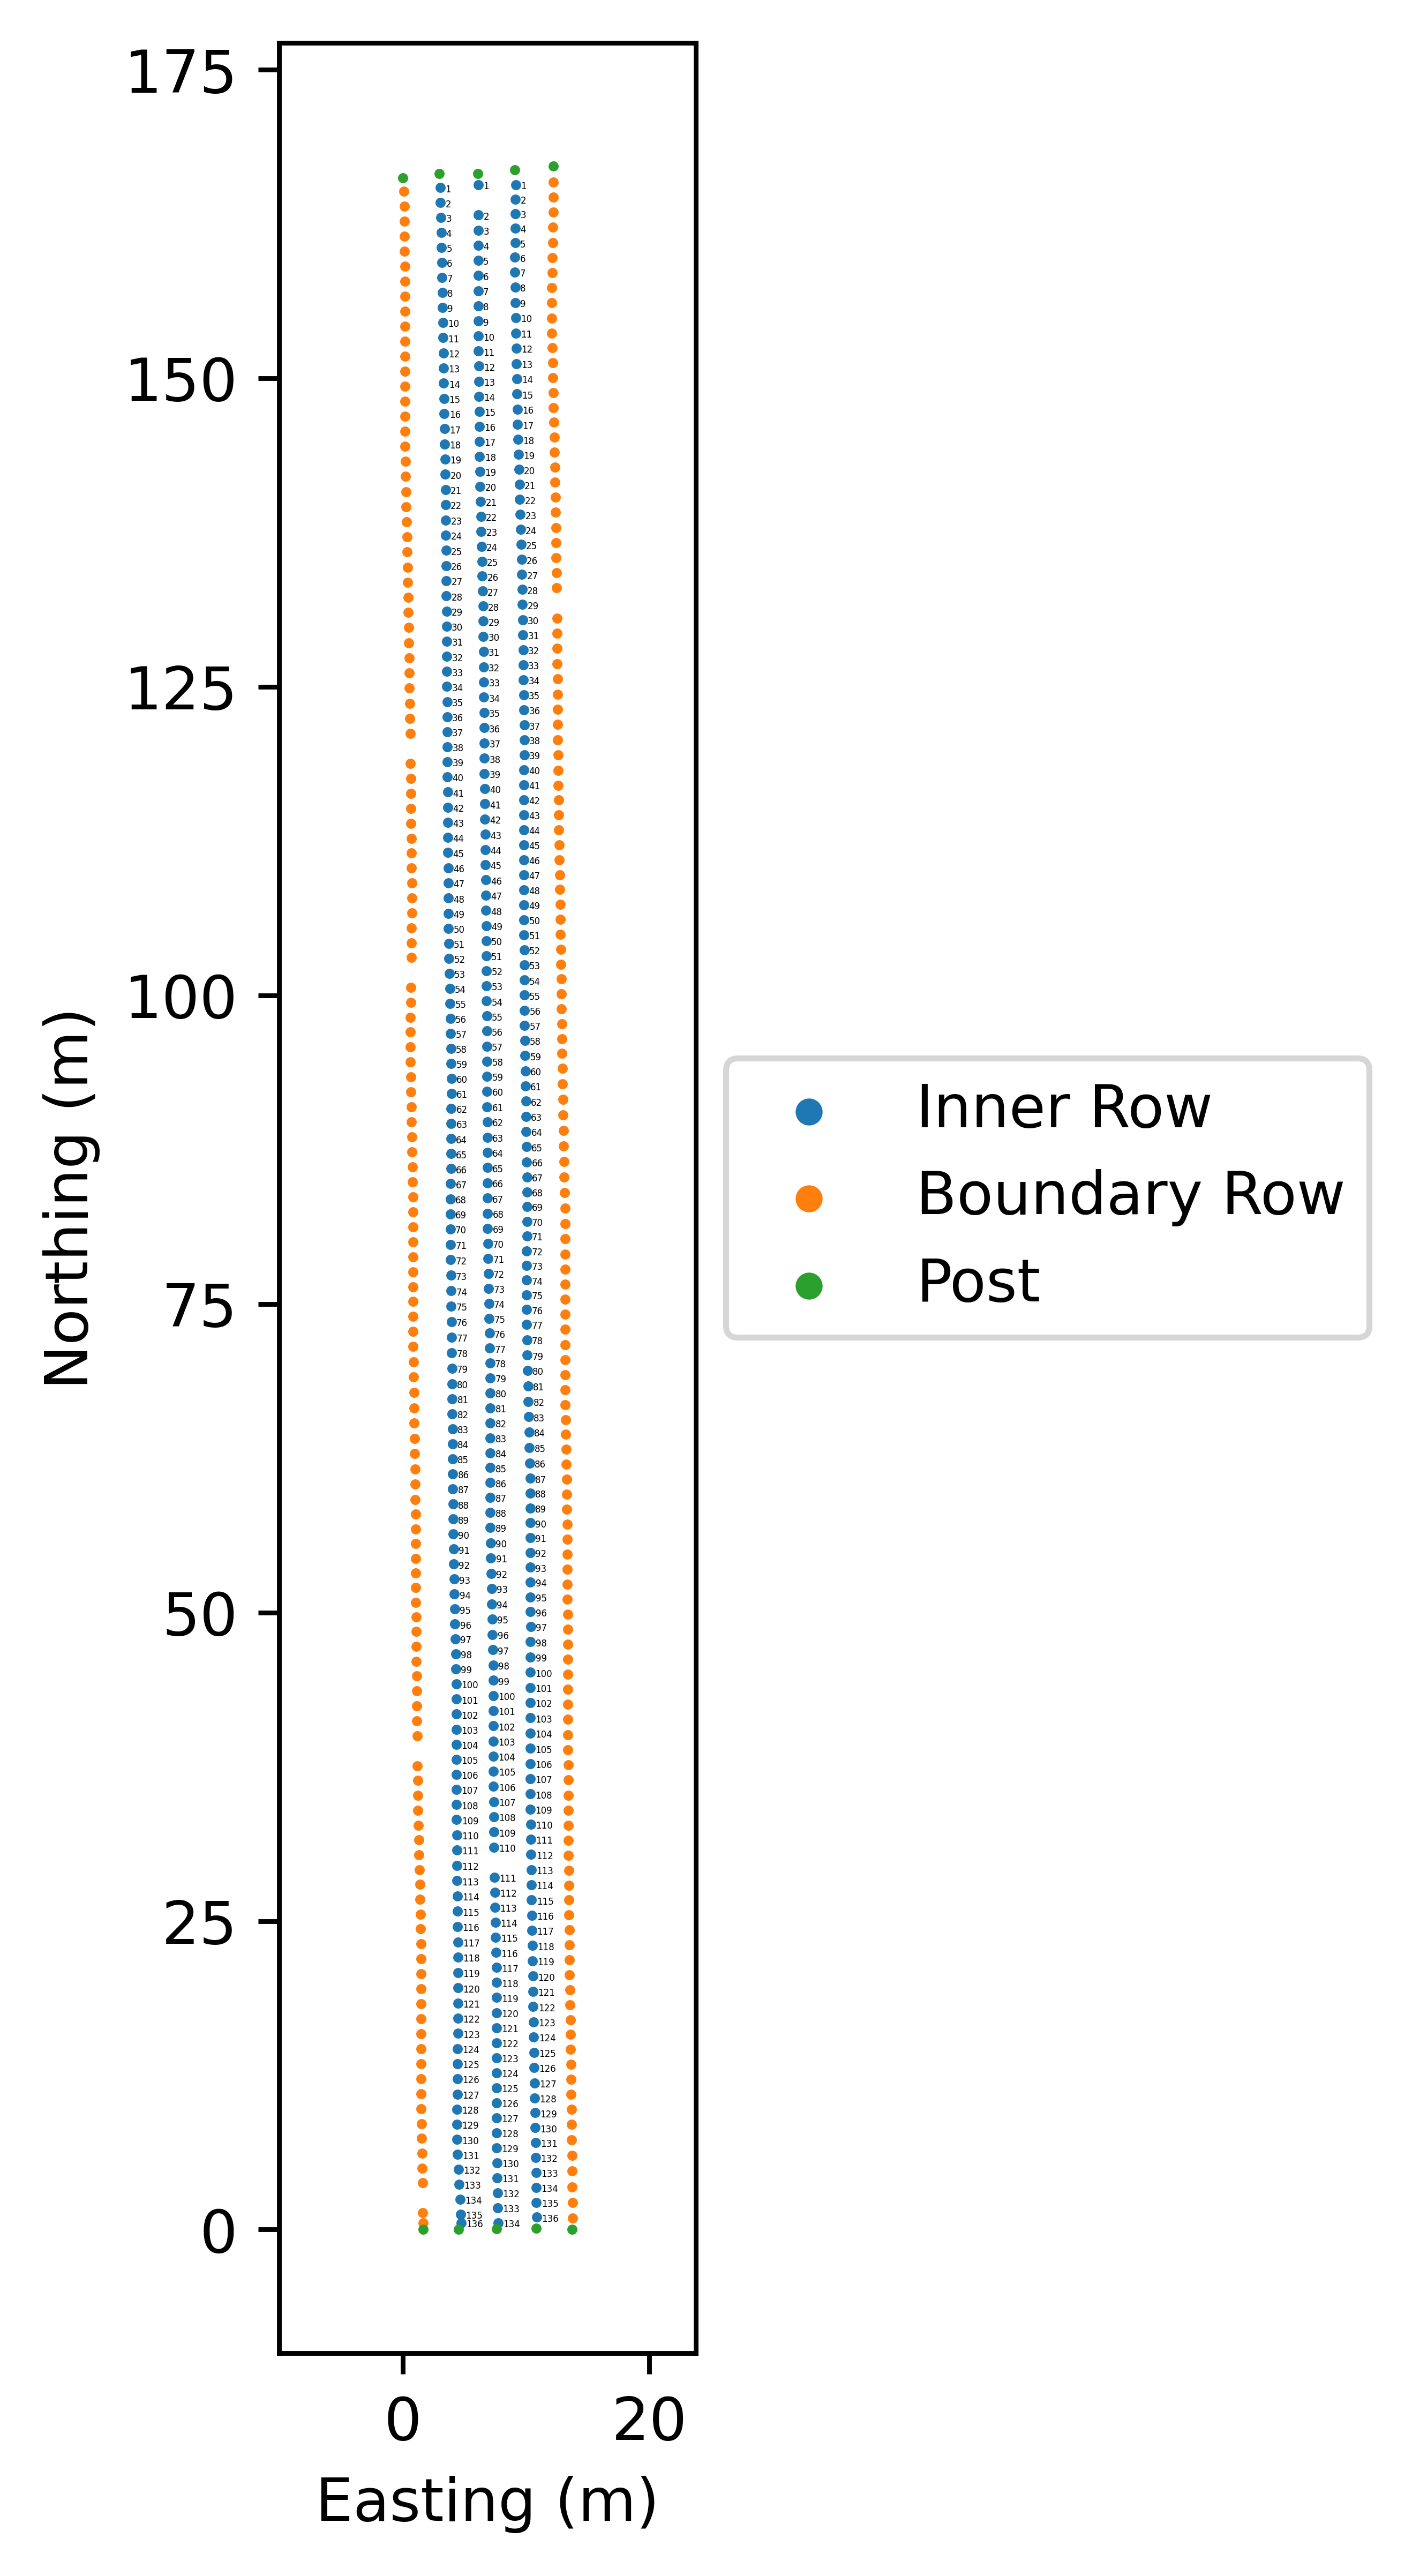

In [14]:
def get_new_order(points, groups):
    new_points = np.zeros((len(points), 2))
    new_groups = np.zeros(len(points))
    plant_nums = np.zeros(len(points), dtype=int)

    end_point = 0
    for group_num in [1, 2, 3, 4, 5, 6]:
        idxs = np.where(groups == group_num)[0]
        new_points[end_point:end_point + len(idxs)] = points[idxs]
        new_groups[end_point:end_point + len(idxs)] = groups[idxs]
        plant_nums[end_point:end_point + len(idxs)] = np.arange(1, len(idxs) + 1)
        end_point += len(idxs)

    return new_points, new_groups, plant_nums

sorted_idxs = np.argsort(points[:, 0])
# reverse the order
sorted_idxs = sorted_idxs[::-1]
points = points[sorted_idxs]
groups = groups[sorted_idxs]

points, groups, plant_nums = get_new_order(points, groups)


# In the form (group_number, plant_number)
to_delete = [[1, 135], [1, 105], [1, 53], [1, 38], [3, 2], [3, 112], [5, 29]]

for group_num, plant_num in to_delete:
    idx = np.where((groups == group_num) & (plant_nums == plant_num))[0]
    points = np.delete(points, idx, axis=0)
    groups = np.delete(groups, idx)
    plant_nums = np.delete(plant_nums, idx)

points, groups, plant_nums = get_new_order(points, groups)

plot_points(points, groups, plant_nums=plant_nums)

### Now save the map data and the plot

In [15]:
data = []
for i, plant_num in enumerate(plant_nums):
    data.append({'lat': points[i][0], 'lon': points[i][1], 'group': int(groups[i]), 'plant_number': int(plant_num)})

# map_data = {'group_names': group_names, 'data': data}

project_config.save_data_to_json(data, project_config.map_data_json_path)

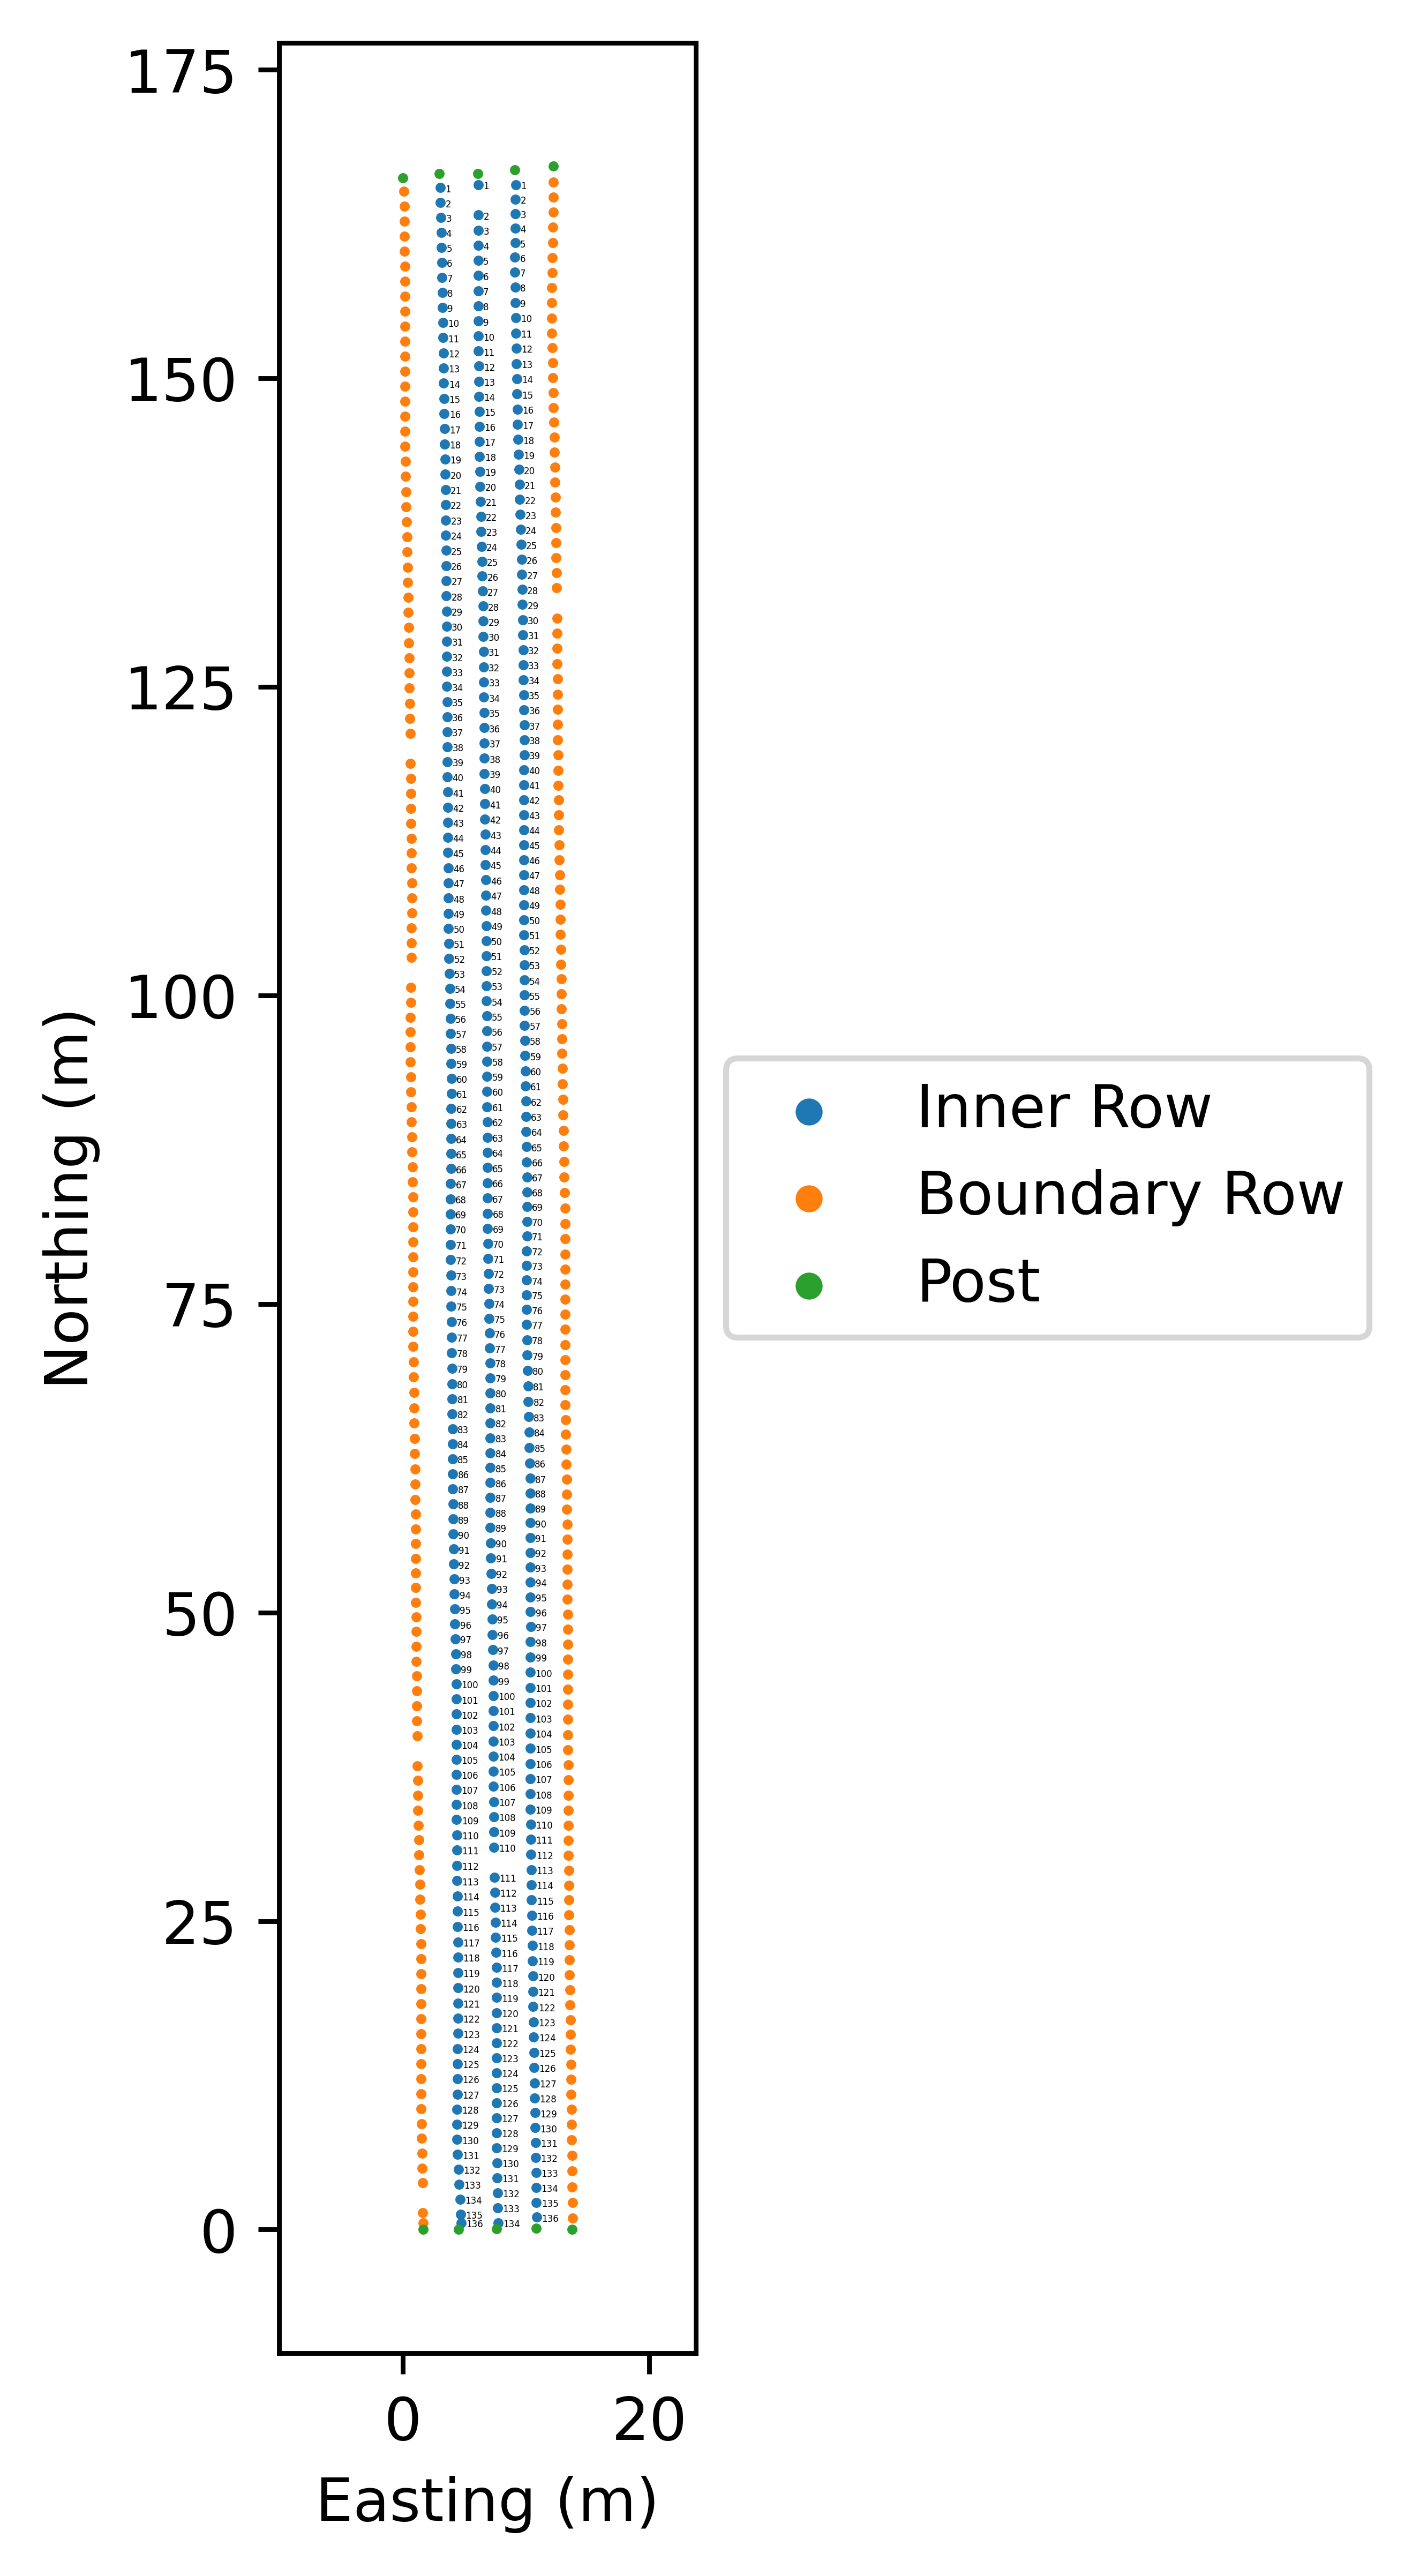

In [16]:
from plotting import plot_map_data
plot_map_data()

### And finally, convert the data to kml and a shapefile

In [17]:
from convert_to_kml import convert_to_kml
from convert_to_shapefile import convert_to_shapefile

convert_to_kml()
convert_to_shapefile()

KML file created successfully.
Shapefile created successfully.
